In [1]:
from pedigree_functions import *
import matplotlib.pyplot as plt
import scipy.stats as stats

C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [2]:
#read genetic map
genmap = pd.read_csv("data/test_data/B73_genmap.csv")
#read parent genotypes
parent_genos = pd.read_csv("data/test_data/NAM_parent_genos.csv")
#read reference allele
ref_allele = pd.read_csv("data/test_data/B73_alleles.csv")

def genotype_simulation(genetic_map, parent_genos, ref_allele, founder_list, offspring, selfing_genos = 5):
    #get founder nodes
    founder_nodes = get_founder_nodes(parent_genos, founder_list)
    #reduce ref_alleles to alleles in genmap
    ref_allele = ref_allele[ref_allele["SNP"].isin(genetic_map["Marker"])]
    #set up pedigree
    pedigree = cross_selfing_ped(offspring = offspring, selfing_genos = selfing_genos)
    #init final genotypes dataframe
    genotypes = pd.DataFrame({"individual": pedigree.loc[pedigree["time"] == 0, "id"]})
    #loop over each chromosome, append results (treats chromosomes entirely independent)
    for i in genmap["Chromosome"].unique():
        #reduce genetic map to chr_i
        chr_genmap = genmap.loc[genmap["Chromosome"] == i]
        #set up rate map for chr_i
        chr_rate_map = get_rate_map(chr_genmap)
        #get chr_i length
        chr_len = chr_genmap["Position(bp)"].max()
        #turn pedigree into ts with chr_i length
        chr_ts = df_to_ts(pedigree, seq_len=chr_len)
        #simulate chr_i ARG
        chr_arg = msprime.sim_ancestry(initial_state = chr_ts, model="fixed_pedigree", recombination_rate = chr_rate_map)
        #propagate ARG recombinations to offspring genotypes
        chr_geno_sim = propagate_geno(chr_arg, founder_nodes, chr_genmap)
        #join haploid offspring simulation nodes to diploid individuals
        chr_genotypes = join_nodes(chr_arg, chr_geno_sim)
        #merge chr_i genotypes to final genotypes
        genotypes = pd.merge(genotypes, chr_genotypes, on = "individual", how = "inner")
        print(f"finished chromsome {i}")
    #recode final genotypes to additive encoding according to reference alleles
    genotypes_additive = additive_encoding(ref_allele, genotypes)

    return(genotypes_additive)

In [3]:
whole_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
                                founder_list = list(["B73", "CML103"]), offspring = 194, selfing_genos = 5)

finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10


In [4]:
whole_sim

SNP,PHM10225.15,PHM10321.11,PHM10404.8,PHM11114.7,PHM11226.13,PHM11985.27,PHM1218.6,PHM12706.14,PHM12749.13,PHM1275.22,...,kip1.3,lac1.3,sh2.21,umc128.2,umc13.1,vdac1a.1,wx1.1,zb21.1,zb27.1,zfl2.9
individual,,,,,,,,,,,,,,,,,,,,,
972,0,0,0,0,0,0,0,0,0,1,...,0,0,2,0,0,0,0,0,2,2
973,0,0,0,0,2,2,0,0,0,2,...,0,2,0,0,2,0,0,0,0,0
974,0,0,0,1,0,1,0,0,2,2,...,0,0,2,0,2,0,2,0,2,2
975,0,0,0,2,0,0,0,0,2,2,...,0,0,2,0,2,0,0,0,2,2
976,2,0,0,0,0,2,0,0,2,2,...,0,0,0,0,2,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2,0,0,1,0,2,0,0,0,2,...,0,2,0,0,2,0,0,0,0,2
1162,2,0,0,0,0,0,0,0,2,0,...,0,0,0,0,2,0,2,0,0,2
1163,0,0,0,2,0,2,0,0,2,2,...,0,0,1,0,2,0,0,0,1,0


In [5]:
pd.Series(whole_sim.values.flatten().tolist()).value_counts()

0    124724
2     60105
1      4127
Name: count, dtype: int64

In [6]:
whole_sim.sum(axis = 1).mean()

640.9123711340206

In [7]:
whole_sim.sum(axis = 1).var()

14801.10627103253

In [54]:
#get mean and sd + variance of simulation replicates
mean = []
var = []
for i in range(0,10):
    whole_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
                                founder_list = list(["B73", "B97"]), offspring = 194, selfing_genos = 5)
    mean.append(whole_sim.sum(axis = 1).mean())
    var.append(whole_sim.sum(axis = 1).var())

finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10
finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10
finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10
finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10
finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished 

In [59]:
np.mean(mean)

625.6159793814434

In [56]:
np.std(mean)

9.311030149362745

In [60]:
np.mean(var)

16742.91505528551

In [58]:
np.std(var)

2087.783198123807

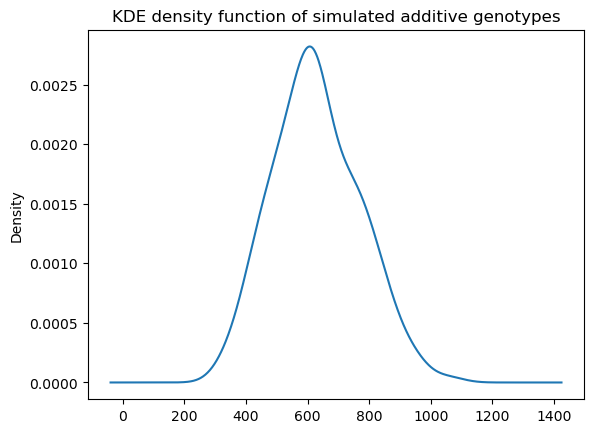

In [70]:
whole_sim.sum(axis = 1).plot.kde()
plt.title("KDE density function of simulated additive genotypes")
plt.savefig("plots/KDE_sim.png")

In [51]:
stats.kstest(whole_sim.sum(axis = 1), "norm")

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=289, statistic_sign=-1)

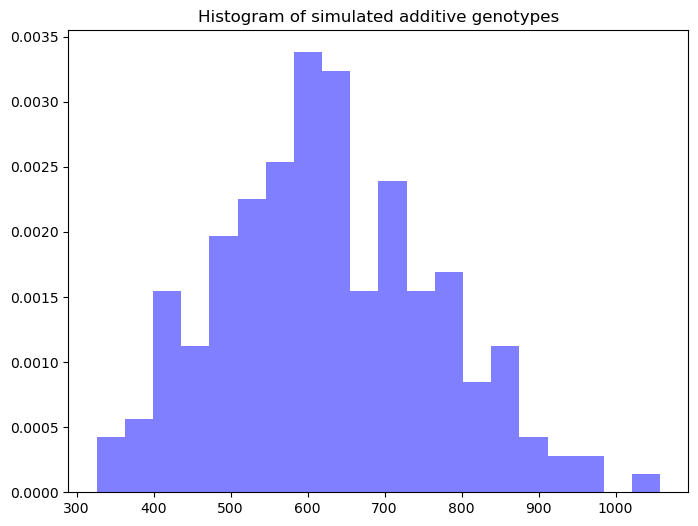

In [69]:
#plt density of additive genotypes
plt.figure(figsize = (8,6))
plt.hist(whole_sim.sum(axis = 1), bins = 20, density = True, alpha = 0.5, color = "b")
plt.title("Histogram of simulated additive genotypes")
plt.savefig("plots/Hist_sim.png")

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
# Reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [8]:
#population one genotypes and allele frequencies
pop_1_genos = pd.read_csv("data/test_data/pop_2_genos.csv")
pop_1_genos = pop_1_genos[pop_1_genos.columns.intersection(genmap["Marker"])]

In [9]:
pop_1_genos

,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,...,PZA03607.1,PZA00130.9,PZA02969.9,PZA02049.1,PZA00007.1,PHM5435.25,PZA01073.1,PZA01001.2,PZA02578.1,PZA00062.4
0,2,2,2.0,2.0,1.5,1.0,1.0,1,1,1.5,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
1,2,2,2.0,2.0,2.0,2.0,2.0,2,2,2.0,...,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2
2,0,0,0.0,0.0,0.0,1.0,1.0,1,1,1.0,...,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2
3,0,0,0.0,0.0,0.0,2.0,2.0,2,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
4,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.5,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2,2,2.0,2.0,2.0,2.0,2.0,2,2,2.0,...,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
192,2,2,2.0,2.0,0.0,0.0,0.0,0,0,0.0,...,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
193,2,2,2.0,2.0,2.0,2.0,2.0,2,2,2.0,...,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2
194,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,1.0,1.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2


In [10]:
pop_1_genos.sum(axis = 1).mean()

1001.5204081632653

In [11]:
pop_1_genos.sum(axis = 1).var()

35802.91496598639

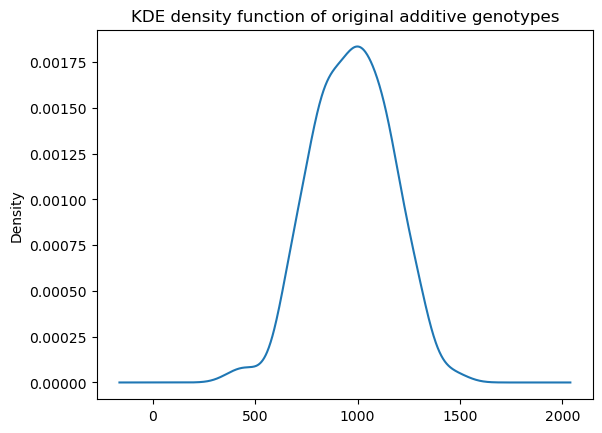

In [68]:
pop_1_genos.sum(axis = 1).plot.kde()
plt.title("KDE density function of original additive genotypes")
plt.savefig("plots/KDE_original.png")

In [37]:
stats.kstest(pop_1_genos.sum(axis = 1), "norm")

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=387.5, statistic_sign=-1)

In [38]:
pop_1_genos.sum(axis = 1).value_counts()

1101.0    3
1092.5    2
899.0     2
977.0     2
808.5     2
         ..
772.5     1
784.0     1
1276.5    1
978.0     1
626.5     1
Name: count, Length: 181, dtype: int64

In [39]:
pd.Series(pop_1_genos.values.flatten().tolist()).value_counts()

0.0    86689
2.0    86050
1.0    12850
0.5     1776
1.5     1591
Name: count, dtype: int64

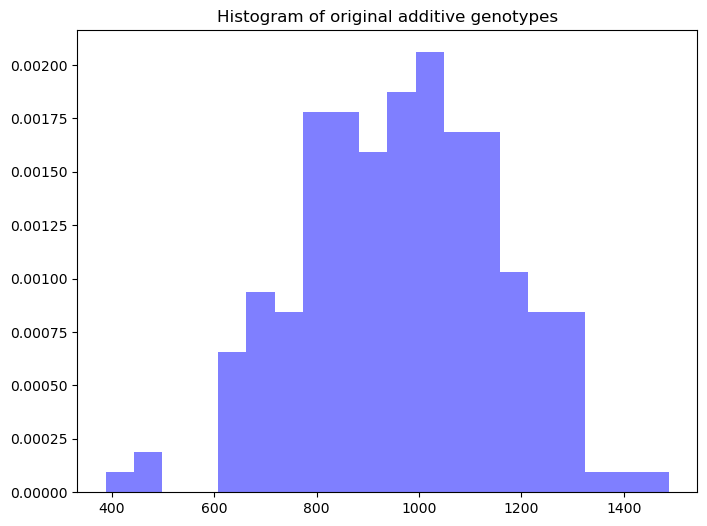

In [71]:
#plt density of additive genotypes
plt.figure(figsize = (8,6))
plt.hist(pop_1_genos.sum(axis = 1), bins = 20, density = True, alpha = 0.5, color = "b")
plt.title("Histogram of original additive genotypes")
plt.savefig("plots/Hist_original.png")

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

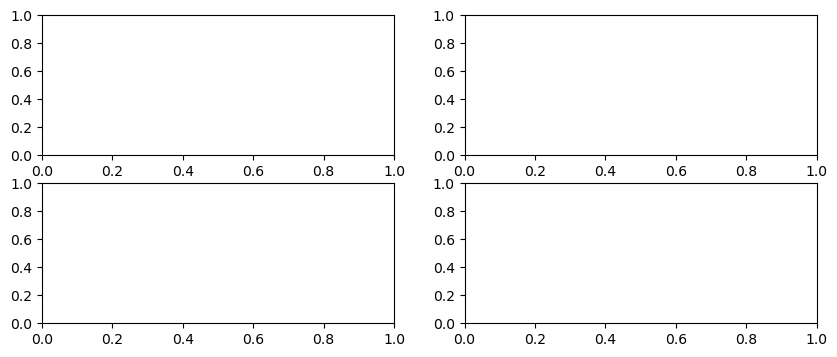

In [62]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,4))
axes[0].plot(pop_1_genos.sum(axis = 1).plot.kde())

In [ ]:
#set up and simulation for 1 chromosome
#requires: genomic map, parent genotypes
#builds: arbitrary pedigree, founder nodes
#simulates: ARG based on pedigree and genomic map, offspring genotypes of pedigree based on ARG and parent genotypes

#simulate genotypes of one population combination (e.g. pop 1 (B73×B97)S5)
#sim ancestry with pedigree similar to pop (~150 offspring + 5 selfing genos)

#load genmap chr1 or load entire genmap and use chr column to reduce -> in full script loop over chr and concat geno_sims
genmap = pd.read_csv("data/test_data/B73_genmap_chr1.csv")
chr1_rate_map = get_rate_map(genmap)

#set up pedigree
pop_1_ped_df = cross_selfing_ped(selfing_genos = 5)
pop_1_ped = df_to_ts(pop_1_ped_df, seq_len=297570924)
#load snp positions not strictly required since all information in genetic map 
#SNP_positions = pd.read_csv("data/test_data/NAM_SNP_positions.csv")

#reduce SNPs to chr1 of genetic map
#chr_1_SNP_positions = SNP_positions[SNP_positions["Marker"].isin(genmap["Marker"])]

#read parent genotypes
parent_genos = pd.read_csv("data/test_data/NAM_parent_genos.csv")

#choose which parents to cross
founder_nodes = get_founder_nodes(parent_genos, list(["B73", "B97"]))

#simulate chromosome 1
chr1_arg = msprime.sim_ancestry(initial_state = pop_1_ped, model="fixed_pedigree", recombination_rate = chr1_rate_map)

#propagate ARG recombinations to offspring genotypes
geno_sim = propagate_geno(chr1_arg, founder_nodes, genmap)

#join haploid offspring simulation nodes to diploid individuals
genotypes = join_nodes(chr1_arg, geno_sim)

#read reference allele
ref_allele = pd.read_csv("data/test_data/B73_alleles.csv")

#reduce ref_alleles to alleles in genmap
ref_allele = ref_allele[ref_allele["SNP"].isin(genmap["Marker"])]

#recode genotype values into additive encoding
geno_add = additive_encoding(ref_allele, genotypes)

In [ ]:
#results
#draw_pedigree(pop_1_ped.tree_sequence())
#print(chr1_arg.dump_tables())
#geno_sim
#genotypes
#geno_add

In [29]:
#calculate rogers and neis distance between real pop and simulated pop
#calculate allele frequencies
def calc_allele_freq(matrix, alleles = 3):
    num_individuals = len(matrix)
    num_snps = len(matrix[0])
    num_alleles = alleles
    allele_frequencies = []

    for j in range(num_snps):
        allele_counts = [0] * num_alleles

        for i in range(num_individuals):
            allele_counts[matrix[i][j]] += 1

        snp_frequencies = [count / num_individuals for count in allele_counts]
        allele_frequencies.extend(snp_frequencies)

    return allele_frequencies

#rogers distance

#neis distance
def neis_distance(X):
    #matrix product of X and its transpose
    d = np.matmul(X, X.T)
    
    #sqrt of diagonal elements
    vec = np.sqrt(np.diag(d))
    
    #Normalize columns of d
    d /= vec[:, np.newaxis]
    
    #Normalize rows of d
    d /= vec
    
    #negative logarithm
    d = -np.log(d)
    
    #todistance matrix
    d = np.asarray(d)
    
    return d

In [33]:
pop_1_genos_list = pop_1_genos.values.astype(int).tolist()
pop_1_genos_allele_freq = calc_allele_freq(pop_1_genos_list)
pop_1_genos_allele_freq

[0.4742268041237113,
 0.061855670103092786,
 0.4639175257731959,
 0.4690721649484536,
 0.07216494845360824,
 0.4587628865979381,
 0.4948453608247423,
 0.05670103092783505,
 0.4484536082474227,
 0.5,
 0.05670103092783505,
 0.44329896907216493,
 0.5051546391752577,
 0.07731958762886598,
 0.4175257731958763,
 0.4484536082474227,
 0.1958762886597938,
 0.3556701030927835,
 0.4484536082474227,
 0.1958762886597938,
 0.3556701030927835,
 0.4948453608247423,
 0.06701030927835051,
 0.4381443298969072,
 0.4948453608247423,
 0.06701030927835051,
 0.4381443298969072,
 0.4845360824742268,
 0.10824742268041238,
 0.4072164948453608,
 0.5,
 0.061855670103092786,
 0.4381443298969072,
 0.4896907216494845,
 0.10309278350515463,
 0.4072164948453608,
 0.4896907216494845,
 0.10309278350515463,
 0.4072164948453608,
 0.5,
 0.08247422680412371,
 0.4175257731958763,
 0.4742268041237113,
 0.15979381443298968,
 0.36597938144329895,
 0.4742268041237113,
 0.15979381443298968,
 0.36597938144329895,
 0.520618556701031

In [24]:
#examples for neis distance and allele frequency functions
X = np.array([[1.0, 3.0, 5.0], [2.0, 4.0, 6.0]])

In [25]:
X

array([[1., 3., 5.],
       [2., 4., 6.]])

In [25]:
neis_distance(X)

array([[-0.        ,  0.00616024],
       [ 0.00616024, -0.        ]])

In [50]:
#example (max distance of pop with 4 individauls vs 3 individuals)
matrix_1 = [
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
]
matrix_2 = [
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [0, 1, 1, 1]
]

freq_1 = calculate_allele_frequency(matrix_1)
freq_2 = calculate_allele_frequency(matrix_2)
print(freq_2)

[0.3333333333333333, 0.6666666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]


In [51]:
X = np.array(list([freq_1, freq_2]))

In [52]:
neis_distance(X)

array([[-0.        ,  2.42601513],
       [ 2.42601513, -0.        ]])